In [1]:
#| default_exp advanced_wrapping

In [2]:
#| export

from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import registration as tcreg
from blender_tissue_cartography import wrapping as tcwrap

import numpy as np
from copy import deepcopy
import warnings
import igl

from scipy import sparse
import shutil

In [3]:
from tqdm.notebook import tqdm
from importlib import reload

import matplotlib.pyplot as plt

In [4]:
np.set_printoptions(suppress=True)

## Advanced wrapping

In this notebook we present some additional wrapping algorithms. So far, we have wrapped two meshes by simply projection each source mesh vertex onto the closest position on the target mesh. This works, but has drawbacks when there are large, localized deformations.

We can think of the wrapping process like stretching the source surface to fit onto the target surface. The "closest point" method effectively gives the source surface zero elastic resistance during the stretching. This means that small regions will capture all deformations, leading to poor results.

Here, we'll look into alternative algorithms which implement some form of effective elasticity.

#### Loading test data

Let's load the test meshes from the fly midgut

In [5]:
meshes_dict = {i: tcio.read_other_formats_without_uv(f"movie_example/meshes/mesh_{str(i).zfill(2)}.ply")
               for i in tqdm(range(1, 32))}

  0%|          | 0/31 [00:00<?, ?it/s]

In [6]:
mesh_initial_UV = tcio.ObjMesh.read_obj("movie_example/initial_uv.obj")
mesh_final_UV = tcio.ObjMesh.read_obj("movie_example/final_uv.obj") # this is a UV map defined for tpt 20

### Reverse wrapping

In [13]:
reload(tcwrap)

<module 'blender_tissue_cartography.wrapping' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py'>

In [14]:
t_final = 20
meshes_wrapped_reverse = {20: mesh_final_UV}

In [15]:
for i in tqdm(reversed(range(1, t_final))):
    print(i)
    mesh_source = meshes_wrapped_reverse[i+1]
    mesh_target = meshes_dict[i]
    # register using ICP
    trafo_centroid_intertia, _ = tcreg.align_by_centroid_and_intertia(mesh_source.vertices, mesh_target.vertices,
                                    q=0.01, shear=True, choose_minimal_rotation=True)
    trafo_icp, _, _ = tcreg.icp(mesh_source.vertices, mesh_target.vertices, initial=trafo_centroid_intertia,
                                threshold=1e-4, max_iterations=20, include_scaling=True, n_samples=5000)
    mesh_registered = mesh_source.apply_affine_to_mesh(trafo_icp)
    # shrink-wrap
    mesh_wrapped = tcwrap.shrinkwrap_igl(mesh_registered, mesh_target,
                                         n_iter_smooth_target=2, n_iter_smooth_wrapped=2)
    mesh_wrapped = tcwrap.smooth_laplacian_on_surface(mesh_wrapped, n_iter=5, lamb=0.5, n_iter_laplace=10)
    # append to list
    mesh_wrapped.write_obj(f"movie_example/meshes_wrapped_reverse/mesh_{str(i).zfill(2)}_wrapped_reverse.obj")
    meshes_wrapped_reverse[i] = mesh_wrapped

0it [00:00, ?it/s]

19
18
17
16


/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:192: RuntimeWarning: Warning: 2 normal(s) flipped during shrink-wrapping
  return mesh_wrapped


15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


### Non-rigid ICP

Try it out first using trimesh, then do myself to avoid dependency

In [17]:
from blender_tissue_cartography import interface_trimesh as inttri
import trimesh

## Other stuff

Use `igl.intrinsic_delaunay_triangulation` (with the standard cut/reglue trick) to improve mesh quality?



### Thin-plate spline registration

### Laplace Beltrami based

In [137]:
from blender_tissue_cartography import remesh_pymeshlab as tcremesh

Unable to load the following plugins:

	libio_e57.so: libio_e57.so does not seem to be a Qt Plugin.

Cannot load library /home/nikolas/Programs/miniconda3/envs/blender-tissue-cartography/lib/python3.11/site-packages/pymeshlab/lib/plugins/libio_e57.so: (/lib/x86_64-linux-gnu/libp11-kit.so.0: undefined symbol: ffi_type_pointer, version LIBFFI_BASE_7.0)



In [139]:
mesh = mesh_initial_UV

In [140]:
mesh_isotropic = tcremesh.remesh_pymeshlab(mesh,)

In [141]:
mesh = mesh_isotropic

In [142]:
laplacian = igl.cotmatrix(mesh.vertices, mesh.tris)

In [143]:
mass = igl.massmatrix(mesh.vertices, mesh.tris)
mass_inv = sparse.diags(1/mass.diagonal(0)) # I think the mass matrix is diagonal

In [144]:
laplacian_uniform = tcwrap.get_uniform_laplacian(mesh.tris) # this yields a very "spiky" embedding

In [145]:
laplacian, laplacian_uniform

(<9786x9786 sparse matrix of type '<class 'numpy.float64'>'
 	with 68490 stored elements in Compressed Sparse Column format>,
 <9786x9786 sparse matrix of type '<class 'numpy.float64'>'
 	with 68490 stored elements in Compressed Sparse Row format>)

In [146]:
## Should we solve the generalized eigenvalue problem with mass matrix?

In [166]:
%%time
#eigen_vals, eigen_vecs = sparse.linalg.eigsh(-laplacian, k=20, ncv=100, which="SM")
eigen_vals, eigen_vecs = sparse.linalg.eigsh(-laplacian, M=mass, k=10, ncv=100, which="SM")

eigen_vals, eigen_vecs = (eigen_vals[1:], eigen_vecs[:, 1:])

CPU times: user 2.41 s, sys: 333 ms, total: 2.74 s
Wall time: 975 ms


In [167]:
eigen_vals = eigen_vals/eigen_vals[0]
eigen_vecs = eigen_vecs / np.abs(eigen_vecs).mean()

In [168]:
eigen_vals

array([1.        , 2.6514747 , 2.88387131, 3.38399699, 5.14294796,
       5.47960909, 6.51360909, 8.56043988, 9.35115346])

In [148]:
## how to match the info onto texture vertices for coloring

# Make this into a method in tcio!!

texture_vertex_dict = {v[1]: v[0] for v in tcio.flatten(mesh.faces, max_depth=1) if not np.isnan(v[1])}
matched_vertex_inds = np.array([texture_vertex_dict[i] for i in range(mesh.texture_vertices.shape[0])])

IndexError: invalid index to scalar variable.

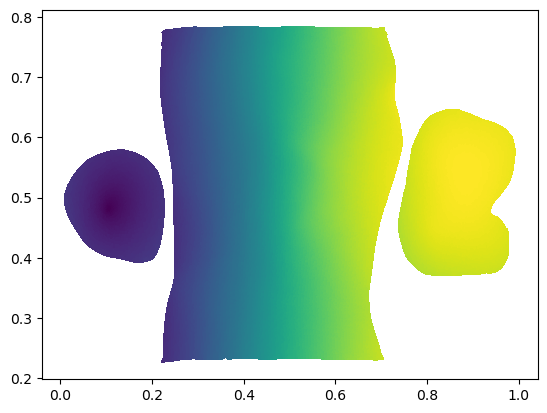

In [136]:
plt.tripcolor(*mesh.texture_vertices.T, mesh.texture_tris, eigen_vecs[matched_vertex_inds,0])

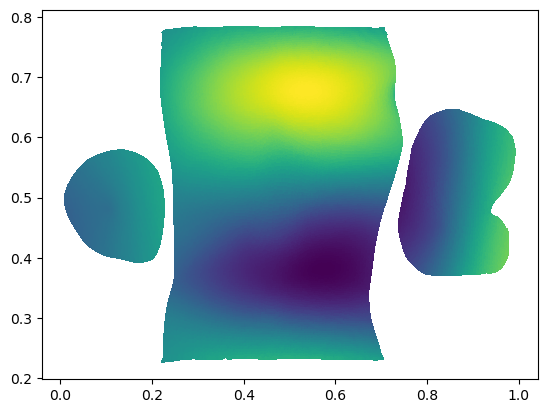

In [135]:
plt.tripcolor(*mesh.texture_vertices.T, mesh.texture_tris, eigen_vecs[matched_vertex_inds,2])

In [173]:
from importlib import reload

In [175]:
reload(tcio)

<module 'blender_tissue_cartography.io' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/io.py'>

In [176]:
mesh_spectral = deepcopy(mesh)

In [177]:
mesh_spectral.vertices = scale*eigen_vecs[:,:3] / eigen_vals[:3]

In [178]:
mesh_spectral.write_obj("movie_example/spectral_final.obj")

UnboundLocalError: cannot access local variable 'vlines' where it is not associated with a value

In [159]:
mesh_spectral.vertices

array([[ 209825.42932012,  -15498.25665452,   14729.27019992],
       [ 207994.03009712,  -15326.90257615,   13164.44313928],
       [ 209305.29977543,  -15307.51509034,   14398.30281343],
       ...,
       [-133615.83793358,  -54727.02067814,   11245.97247909],
       [ -77738.0780818 ,  -62417.56706647,   34429.69811157],
       [ -76443.93307173,  -57082.35901087,  -40935.16738506]])

In [154]:
help(sparse.linalg.eigsh)

Help on function eigsh in module scipy.sparse.linalg._eigen.arpack.arpack:

eigsh(A, k=6, M=None, sigma=None, which='LM', v0=None, ncv=None, maxiter=None, tol=0, return_eigenvectors=True, Minv=None, OPinv=None, mode='normal')
    Find k eigenvalues and eigenvectors of the real symmetric square matrix
    or complex Hermitian matrix A.
    
    Solves ``A @ x[i] = w[i] * x[i]``, the standard eigenvalue problem for
    w[i] eigenvalues with corresponding eigenvectors x[i].
    
    If M is specified, solves ``A @ x[i] = w[i] * M @ x[i]``, the
    generalized eigenvalue problem for w[i] eigenvalues
    with corresponding eigenvectors x[i].
    
    Note that there is no specialized routine for the case when A is a complex
    Hermitian matrix. In this case, ``eigsh()`` will call ``eigs()`` and return the
    real parts of the eigenvalues thus obtained.
    
    Parameters
    ----------
    A : ndarray, sparse matrix or LinearOperator
        A square operator representing the operation `